<a href="https://colab.research.google.com/github/sahug/ds-tensorflow-colab/blob/master/Tensorflow%20-%20Bank%20Customer%20Satisfaction%20Using%20CNN%20and%20Feature%20Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tensorflow - Bank Customer Satisfaction Using CNN and Feature Selection**

**Import Libraries**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization

In [2]:
print(tf.__version__)

2.8.0


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

**Load Dataset**

In [22]:
# Read Data
data = pd.read_csv("data/santander-train.csv")
data.head()

# target is 0 - Unsattisfied and 1 Satisfied in below data.

data.shape

(76020, 371)

**Remove Duplicates**

In [23]:
def dropDuplicates(ds):        
    return pd.DataFrame(ds).drop_duplicates()

data = dropDuplicates(data)

data.shape

(76020, 371)

**Drop Unwanted Columns**

In [24]:
from typing import List
def dropUnwantedFeatures(ds, cols: List):
    x = ds.drop(labels=cols, axis=1) # Dropping unnecessary data
    x.shape
    return x

x = dropUnwantedFeatures(data, ["ID", "TARGET"])
y = data["TARGET"] # This is what we are predicting

**Train and Test Split**

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60816, 369), (15204, 369), (60816,), (15204,))

#### **Remove Constant, Quassi Constant and Duplicate Features**

In [32]:
filter = VarianceThreshold(0.01) # Removing 1%
x_train = filter.fit_transform(x_train)
x_test = filter.transform(x_test)

x_train.shape, x_test.shape

((60816, 273), (15204, 273))

**Approach 1**

**Normalize Layer**

In [33]:
def normalizeDataset(ds):
    normalizer = tf.keras.layers.Normalization()    
    normalizer.adapt(ds)    
    return normalizer(ds)

# x_train = normalizeDataset(x_train)
# x_test = normalizeDataset(x_test)

**Model**

In [88]:
input_shape = x_train.shape[1], 1
input_shape

(273, 1)

In [89]:
from keras import activations

def buildModel():
    inputs = keras.Input(shape=(input_shape))

    x = keras.layers.Conv1D(filters=32, kernel_size=3, activation=activations.relu)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool1D(2)(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, activation=activations.relu)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool1D(2)(x)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Conv1D(filters=128, kernel_size=3, activation=activations.relu)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool1D(2)(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(x_train.shape[1], activation=activations.relu)(x)
    x = keras.layers.Dropout(0.5)(x)

    outputs = keras.layers.Dense(1,  activation=activations.sigmoid)(x)

    model = keras.Model(inputs=inputs, outputs=[outputs], name="conv1d")

    # Compile 
    loss = keras.losses.BinaryCrossentropy()
    optim = keras.optimizers.Adam(learning_rate=0.00005)
    # metrics = [keras.metrics.SparseCategoricalAccuracy()]
    metrics = ["accuracy"]

    model.compile(loss=loss, optimizer=optim, metrics=metrics)

    return model

**Classifier for Pipeline**

In [ ]:
%pip install scikeras[tensorflow]

In [90]:
from scikeras.wrappers import KerasClassifier

kwargs = dict(
    model=buildModel(),
    epochs=10,
    batch_size = 128,
    verbose=1,
    random_state=0,
)

clf = KerasClassifier(model=buildModel(), epochs=10)

**Pipeline**

The class below is used to create a pipeline using your custom methods. Here we are using Normalization layer in the pipeline.

In [92]:
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

In [93]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")
pipeline = Pipeline(steps=[
                ("Normalization", DataframeFunctionTransformer(normalizeDataset)),
                ("model", clf)

])
pipeline

Pipeline(steps=[('Normalization',
                 <__main__.DataframeFunctionTransformer object at 0x0000025ABF22C220>),
                ('model',
                 KerasClassifier(epochs=10, model=<keras.engine.functional.Functional object at 0x0000025AC110FCA0>))])

**Train**

In [94]:
pipeline.fit(x_train, y_train)

Epoch 1/10
1901/1901 [==============================] - 87s 45ms/step - loss: 0.2019 - sparse_categorical_accuracy: 0.9604
Epoch 2/10
1901/1901 [==============================] - 101s 53ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.9604
Epoch 3/10
1901/1901 [==============================] - 107s 56ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.9604
Epoch 4/10
1901/1901 [==============================] - 102s 53ms/step - loss: 0.1615 - sparse_categorical_accuracy: 0.9604
Epoch 5/10
1901/1901 [==============================] - 92s 49ms/step - loss: 0.1600 - sparse_categorical_accuracy: 0.9604
Epoch 6/10
1901/1901 [==============================] - 87s 46ms/step - loss: 0.1562 - sparse_categorical_accuracy: 0.9604
Epoch 7/10
1901/1901 [==============================] - 84s 44ms/step - loss: 0.1545 - sparse_categorical_accuracy: 0.9604
Epoch 8/10
1901/1901 [==============================] - 79s 42ms/step - loss: 0.1522 - sparse_categorical_accuracy: 0.9604
Epoch 9/10
19

Pipeline(steps=[('Normalization',
                 <__main__.DataframeFunctionTransformer object at 0x0000025ABF22C220>),
                ('model',
                 KerasClassifier(epochs=10, model=<keras.engine.functional.Functional object at 0x0000025AC110FCA0>))])

**Make Prediction**

In [101]:
y_preds = clf.predict(tf.cast(x_test, tf.float32))
y_preds[:10], y_preds[10:]

476/476 [==============================] - 3s 6ms/step


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

**Plot History**

In [95]:
clf.history_.keys()

dict_keys(['loss', 'sparse_categorical_accuracy'])

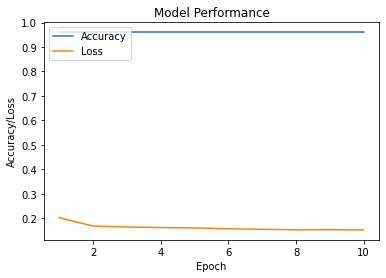

In [98]:
epoch_range = range(1, 11)

# Plot training and validation accuracy values
# sparse_categorical_accuracy vs val_sparse_categorical_accuracy
plt.plot(epoch_range, clf.history_["sparse_categorical_accuracy"])
plt.plot(epoch_range, clf.history_["loss"])
plt.title("Model Performance")
plt.ylabel("Accuracy/Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Loss"], loc="upper left")
plt.show()

**Approach 2**

In [107]:
# Read Data
data = pd.read_csv("data/santander-train.csv")
data.head()

# Drop Duplicates
data = dropDuplicates(data)

# Split Dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

# Remove Constants
filter = VarianceThreshold(0.01) # Removing 1%
x_train = filter.fit_transform(x_train)
x_test = filter.transform(x_test)

# Bringing down the differences.
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Shapes
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60816, 273), (15204, 273), (60816,), (15204,))

**Model**

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(273, 1)))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Conv1D(filters=128, kernel_size=3, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(273, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(1, activation="sigmoid"))

model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=1)

In [ ]:
epoch_range = range(1, 11)

# Plot training and validation accuracy values
# sparse_categorical_accuracy vs val_sparse_categorical_accuracy
plt.plot(epoch_range, history.history["accuracy"])
plt.plot(epoch_range, history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

# Plot training and validation loss values
# Loss vs Val_Loss
plt.plot(epoch_range, history.history["loss"])
plt.plot(epoch_range, history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()